In [1]:
# IMPORTS & ENV SETUP
import os                                  
import math                                
import random
import time                             
import numpy as np                        
import torch                          
import torch.nn as nn                     
import torch.optim as optim              
from torch.utils.data import DataLoader   
from torch.utils.data import random_split  
from torchvision import datasets         
from torchvision import transforms         
import matplotlib.pyplot as plt     
import warnings
warnings.filterwarnings("ignore"),

print(f"Torch version: {torch.__version__}")
print(f"Using device: {'cuda' if torch.cuda.is_available() else 'cpu'}")

WORKING_DIR = 'C:/term_project/'
os.chdir(WORKING_DIR)
print(os.getcwd())

Torch version: 2.9.1+cpu
Using device: cpu
C:\term_project


In [2]:
# LOAD CIFAR-10 DATASET GRAYSCALE

DATA_DIR = './data'

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Why normalize with (0.5,)?
# The CIFAR-10 dataset has pixel values in the range [0, 1] after ToTensor().
# Normalizing with mean=0.5 and std=0.5 scales the pixel values to the range [-1, 1],
# which is often beneficial for training neural networks.

train_dataset = datasets.CIFAR10(
    root=DATA_DIR, 
    train=True, 
    download=True, 
    transform=transform)
    
test_dataset = datasets.CIFAR10(
    root=DATA_DIR, 
    train=False, 
    download=True, 
    transform=transform)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")

100.0%


Number of training samples: 50000
Number of test samples: 10000


Image classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Selected index: 29098
 Image shape: torch.Size([1, 32, 32])
 Image label: 4 (deer)
 Image shape after squeeze: torch.Size([32, 32])
 Image pixel range: min -0.9451, max 0.2941

Selected index: 37593
 Image shape: torch.Size([1, 32, 32])
 Image label: 6 (frog)
 Image shape after squeeze: torch.Size([32, 32])
 Image pixel range: min -0.9843, max 0.9451

Selected index: 31680
 Image shape: torch.Size([1, 32, 32])
 Image label: 8 (ship)
 Image shape after squeeze: torch.Size([32, 32])
 Image pixel range: min -0.8431, max 0.6235

Selected index: 6031
 Image shape: torch.Size([1, 32, 32])
 Image label: 1 (automobile)
 Image shape after squeeze: torch.Size([32, 32])
 Image pixel range: min -0.9608, max 1.0000

Selected index: 6777
 Image shape: torch.Size([1, 32, 32])
 Image label: 6 (frog)
 Image shape after squeeze: torch.Size([32, 32])
 Image pixel range: min -0.8196, max 0.6314

Sele

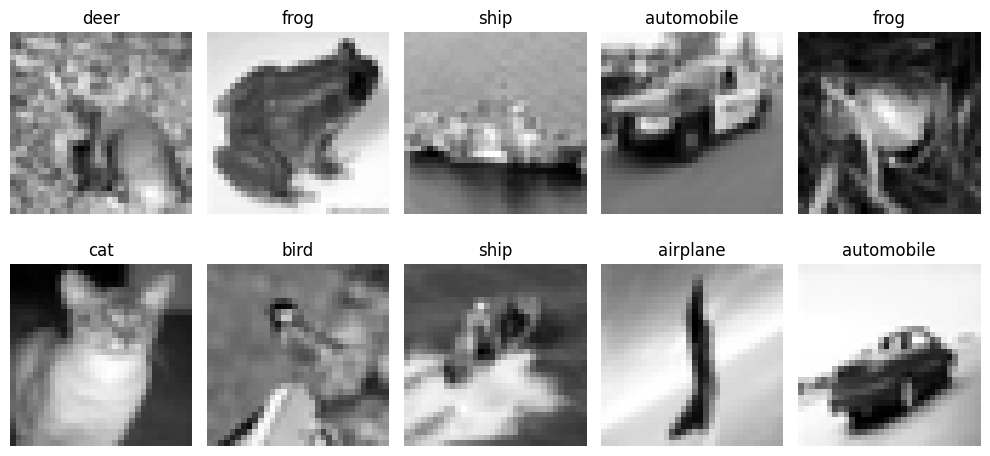

In [3]:
# VISUALIZE SOME SAMPLES

img_classes = train_dataset.classes
print(f"Image classes: {img_classes}")

fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i in range(2):
    for j in range(5):
        idx = random.randint(0, len(train_dataset)-1)
        print(f"\nSelected index: {idx}")
        
        img, label = train_dataset[idx]
        print(f" Image shape: {img.shape}")  # should be [1, 32, 32] for grayscale
        print(f" Image label: {label} ({img_classes[label]})")

        img_squeezed = img.squeeze()
        print(f" Image shape after squeeze: {img_squeezed.shape}")  # should be [32, 32]
        print(f" Image pixel range: min {img.min().item():.4f}, max {img.max().item():.4f}") # should be normalized between -1 and 1

        axes[i, j].imshow(img_squeezed, cmap='gray')
        axes[i, j].set_title(img_classes[label])
        axes[i, j].axis('off')

plt.tight_layout()
plt.show()
plt.close()

In [4]:
# DATA LOADERS & SPLIT

BATCH_SIZE = 64
VAL_SPLIT = 0.1

# What is batch size?
# Batch size is the number of training samples processed before the model's internal parameters are updated.
# It determines how many samples are passed through the network at once during training.

# Split training data into train and validation
train_size = int((1 - VAL_SPLIT) * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Why shuffle=True for train_loader?
# Shuffling the training data helps to ensure that the model does not learn the order of the data,
# which can lead to better generalization and prevents overfitting to the sequence of the training samples.

print(f"Batch size: {BATCH_SIZE}")
print(f"Train samples: {len(train_subset)} ({len(train_loader)} batches)")
print(f"Val samples: {len(val_subset)} ({len(val_loader)} batches)")
print(f"Test samples: {len(test_dataset)} ({len(test_loader)} batches)")

Batch size: 64
Train samples: 45000 (704 batches)
Val samples: 5000 (79 batches)
Test samples: 10000 (157 batches)


In [6]:
# DEFINE FEEDFORWARD NN MODEL

# What is a FeedForward Neural Network?
# A FeedForward Neural Network (FNN) is a type of artificial neural network where the connections between the nodes do not form a cycle.
# In an FNN, information moves in only one direction—from the input nodes, through the hidden nodes (if any), and finally to the output nodes.
# There are no loops or cycles in the network. FNNs are typically used for tasks such as classification and regression.

class FeedForwardNN(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes, dropout_p=0.1):
        super(FeedForwardNN, self).__init__()
        
        # Create a list of layers
        layers = []
        
        # Input layer to first hidden layer
        layers.append(nn.Flatten())
        layers.append(nn.Linear(input_size, hidden_sizes[0]))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout_p))
        
        # Hidden layers
        for i in range(len(hidden_sizes) - 1):
            layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_p))
            
        # Output layer
        layers.append(nn.Linear(hidden_sizes[-1], num_classes))
        
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

# Model parameters
INPUT_SIZE = 32 * 32  # 1024
HIDDEN_SIZES = [512, 256, 128]
NUM_CLASSES = 10

# 1. Flatten Layer: Converts the 2D input image (32x32) into a 1D vector of size 1024.
# 2. First Linear Layer: Fully connected layer that maps the input vector to a hidden layer of size 512.
# 3. ReLU Activation: Applies the ReLU activation function to introduce non-linearity.
# 4. Dropout Layer: Applies dropout with a probability of 0.1 to prevent overfitting.
# 5. Second Linear Layer: Maps the first hidden layer to the second hidden layer of size 256.
# 6. ReLU Activation: Applies ReLU again.
# 7. Dropout Layer: Applies dropout again.
# 8. Third Linear Layer: Maps the second hidden layer to the third hidden layer of size 128.
# 9. ReLU Activation: Applies ReLU again.
# 10. Dropout Layer: Applies dropout again.
# 11. Output Layer: Maps the third hidden layer to the output layer with 10 classes.

# What is Relu Activation?
# The ReLU (Rectified Linear Unit) activation function is defined as f(x) = max(0, x).
# It introduces non-linearity into the model, allowing it to learn complex patterns.
# ReLU is computationally efficient and helps mitigate the vanishing gradient problem,
# making it a popular choice in deep learning models.
# For example, Input -1, 2, -3, 4 -> Output 0, 2, 0, 4

# What are the differences between Relu and Sigmoid activations?
# 1. Range: ReLU outputs values in the range [0, ∞), while Sigmoid outputs values in the range (0, 1).
# 2. Non-linearity: Both are non-linear, but ReLU is piecewise linear, while Sigmoid is smooth and S-shaped.
# 3. Gradient Behavior: ReLU has a constant gradient of 1 for positive inputs, while Sigmoid's gradient diminishes as inputs move away from 0, leading to the vanishing gradient problem.
# 4. Computational Efficiency: ReLU is computationally more efficient than Sigmoid, as it involves simpler mathematical operations.
# 5. Usage: ReLU is commonly used in hidden layers of deep networks, while Sigmoid is often used in output layers for binary classification tasks.

# Why use Dropout?
# Dropout is a regularization technique used to prevent overfitting in neural networks.
# During training, dropout randomly sets a fraction of the input units to zero at each update,
# which helps to break up co-adaptations among neurons.
# This encourages the network to learn more robust features that are useful in conjunction with many different random subsets of the other neurons.
# As a result, dropout can improve the generalization performance of the model on unseen data.

# Define device and instantiate model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FeedForwardNN(INPUT_SIZE, HIDDEN_SIZES, NUM_CLASSES).to(device)
print(model)

FeedForwardNN(
  (model): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1024, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.1, inplace=False)
    (7): Linear(in_features=256, out_features=128, bias=True)
    (8): ReLU()
    (9): Dropout(p=0.1, inplace=False)
    (10): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [7]:
# TRAINING SETUP

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
EPOCHS = 20

# What is an epoch?
# An epoch is one complete pass through the entire training dataset.
# During each epoch, the model sees every training sample once and updates its parameters accordingly.

# What is learning rate?
# The learning rate is a hyperparameter that controls how much to change the model's weights
# in response to the estimated error each time the model's weights are updated.
# A smaller learning rate means the model learns more slowly, while a larger learning rate can speed up learning but may risk overshooting the optimal weights.

# Why use Adam optimizer?
# Adam (Adaptive Moment Estimation) is an optimization algorithm that combines the advantages of two other popular optimizers: AdaGrad and RMSProp.
# It computes adaptive learning rates for each parameter by estimating the first and second moments of the gradients.
# Adam is efficient, requires little memory, and works well in practice for a wide range of deep learning tasks,
# making it a popular choice for training neural networks.

# Training Loop
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

print("Starting training...")
start_time = time.time()

for epoch in range(EPOCHS):
    # Training Phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad() # Zero the parameter gradients
        outputs = model(images) # Forward pass
        loss = criterion(outputs, labels) # Compute loss
        loss.backward() # Backward pass
        optimizer.step() # Update parameters
        
        running_loss += loss.item() # Accumulate loss
        _, predicted = torch.max(outputs.data, 1) # Get predictions
        total += labels.size(0) # Update total count
        correct += (predicted == labels).sum().item() # Update correct predictions
        
    epoch_loss = running_loss / len(train_loader) # Calculate average loss for the epoch
    epoch_acc = 100 * correct / total # Calculate accuracy for the epoch
    train_losses.append(epoch_loss) # Record training loss
    train_accuracies.append(epoch_acc) # Record training accuracy
    
    # Validation Phase
    model.eval() # Set model to evaluation mode, disables dropout and batch normalization
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images) # Forward pass
            loss = criterion(outputs, labels) # Compute loss
            
            val_running_loss += loss.item() # Accumulate loss
            _, predicted = torch.max(outputs.data, 1) # Get predictions
            val_total += labels.size(0) # Update total count
            val_correct += (predicted == labels).sum().item() # Update correct predictions
            
    val_epoch_loss = val_running_loss / len(val_loader) # Calculate average loss for the epoch
    val_epoch_acc = 100 * val_correct / val_total # Calculate accuracy for the epoch
    val_losses.append(val_epoch_loss) # Record validation loss
    val_accuracies.append(val_epoch_acc) # Record validation accuracy
    
    print(f" Epoch [{epoch+1}/{EPOCHS}] "
          f" Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.2f}% | "
          f" Val Loss: {val_epoch_loss:.4f} Acc: {val_epoch_acc:.2f}%")

print(f"\nTraining finished in {time.time() - start_time:.2f}s")

# What is the loss function used here?
# The loss function used here is CrossEntropyLoss, which is commonly used for multi-class classification tasks.
# It combines LogSoftmax and Negative Log Likelihood Loss in one single class.
# It measures the difference between the predicted class probabilities and the true class labels,
# encouraging the model to assign higher probabilities to the correct classes.

Starting training...
 Epoch [1/20]  Train Loss: 1.9140 Acc: 31.42% |  Val Loss: 1.8036 Acc: 36.24%
 Epoch [2/20]  Train Loss: 1.7433 Acc: 38.33% |  Val Loss: 1.7060 Acc: 40.58%
 Epoch [3/20]  Train Loss: 1.6419 Acc: 42.04% |  Val Loss: 1.6480 Acc: 42.34%
 Epoch [4/20]  Train Loss: 1.5669 Acc: 44.60% |  Val Loss: 1.6323 Acc: 43.20%
 Epoch [5/20]  Train Loss: 1.5045 Acc: 46.76% |  Val Loss: 1.5914 Acc: 44.28%
 Epoch [6/20]  Train Loss: 1.4420 Acc: 48.70% |  Val Loss: 1.5952 Acc: 44.58%
 Epoch [7/20]  Train Loss: 1.3904 Acc: 50.76% |  Val Loss: 1.5661 Acc: 46.22%
 Epoch [8/20]  Train Loss: 1.3408 Acc: 52.19% |  Val Loss: 1.5405 Acc: 46.10%
 Epoch [9/20]  Train Loss: 1.3007 Acc: 53.81% |  Val Loss: 1.5810 Acc: 45.80%
 Epoch [10/20]  Train Loss: 1.2540 Acc: 55.40% |  Val Loss: 1.5635 Acc: 46.64%
 Epoch [11/20]  Train Loss: 1.2129 Acc: 56.87% |  Val Loss: 1.5729 Acc: 46.30%
 Epoch [12/20]  Train Loss: 1.1764 Acc: 57.78% |  Val Loss: 1.6100 Acc: 46.88%
 Epoch [13/20]  Train Loss: 1.1332 Acc: 

Test Loss: 1.7788
Test Accuracy: 46.05%


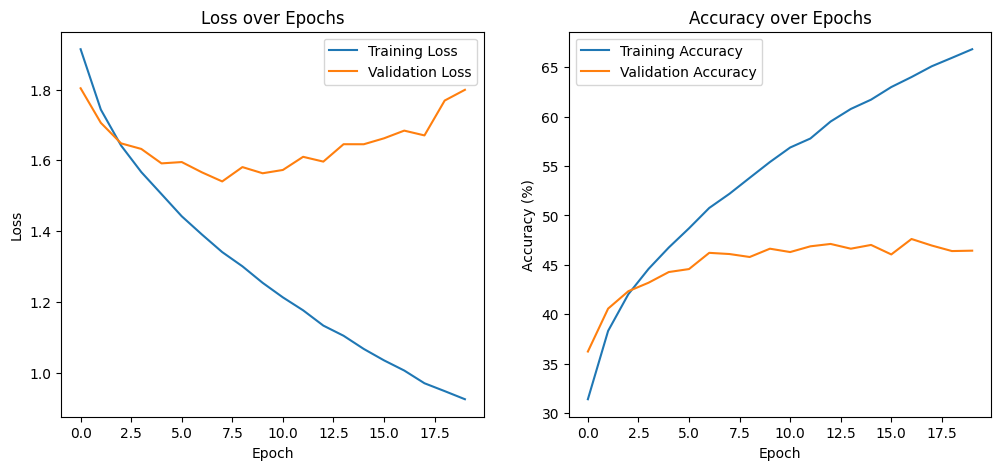

In [8]:
# EVALUATION

model.eval() # Set model to evaluation mode, disables dropout and batch normalization
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader: 
        images, labels = images.to(device), labels.to(device)
        outputs = model(images) # Forward pass
        loss = criterion(outputs, labels) # Compute loss
        test_loss += loss.item() # Accumulate loss
        _, predicted = torch.max(outputs.data, 1) # Get predictions
        total += labels.size(0) # Update total count
        correct += (predicted == labels).sum().item() # Update correct predictions

avg_test_loss = test_loss / len(test_loader) # Calculate average test loss
test_acc = 100 * correct / total # Calculate test accuracy

print(f"Test Loss: {avg_test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2f}%")

# Plot training curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

In [ ]:
# FINAL COMMENTS

# 1. Data Splitting Strategy
# Splitting: Training set split into 90% for training (45,000 samples) and 10% for validation (5,000 samples) using random_split.
# Loaders: Batch size of 64; training loader shuffled for randomization, validation and test loaders not shuffled.
# Transforms: Grayscale conversion, ToTensor (scales to [0,1]), and Normalize with mean=0.5, std=0.5 (maps to [-1,1]).

# 2. Performance of the model
# Training Results: Over 20 epochs with Adam optimizer (lr=0.001), training accuracy improved from 31% to 67%,
# Validation: But val accuracy sticked at 46-47%, indicating overfitting.
# Test Results: Final test accuracy 46.05%, test loss 1.7788 (CrossEntropyLoss).
# Overall: The model achieves 46% accuracy.

# 3. Loss Function Evaluation
# Loss Function: nn.CrossEntropyLoss, which combines LogSoftmax and Negative Log Likelihood Loss for multi-class classification. 
# It measures the difference between predicted logits and true labels, penalizing incorrect predictions.